In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras import backend as K
from keras.layers import Layer, Input, Conv2D, MaxPooling2D
import tensorflow as tf

In [2]:
#base_model test
import base_model
base = base_model.Base()
fmap = base.get_fmap()
base.get_config()

{'name': 'base',
 'trainable': True,
 'dtype': 'float32',
 'base': 'VGG16',
 'channels': 3,
 'input_shape': TensorShape([None, None, None, 3]),
 'fmap_shape': TensorShape([None, None, None, 512])}

In [3]:
#pooling test
import roi_pooling

#test pool.call after the rois are generated
pool = roi_pooling.RoIPooling(pool_size = 7, num_rois = 1)
pool.get_config()

{'name': 'ro_i_pooling',
 'trainable': True,
 'dtype': 'float32',
 'pool_size': 7,
 'num_rois': 1}

## Testing Region Proposals (generate.py)

In [4]:
from rpn.generate_anchors import generate_anchor_boxes
import config as C

#if image big, we resize it
def resize(img):
    w,h,_ = img.shape
    if w>h:
        scaling_factor = h/600
    else:
        scaling_factor = w/600
    return cv2.resize(img,(int(h/scaling_factor),int(w/scaling_factor)))

def plot_rectangles(imdb,img):
    for idx in range(len(imdb)):
        im = imdb.loc[idx]
        #print(im['x1'],im['y1'],im['x2'],im['y2'])
        if im['class']!='bg':
            cv2.rectangle(img,(int(im['x1']),int(im['y1'])),(int(im['x2']),int(im['y2'])),(255,0,0),2)
    plt.figure(figsize=(10,10))
    plt.imshow(img[:,:,[2,1,0]])

def plot_boxes(img, y_rpn_cls):
    anchor_ratios = C.anchor_box_ratios
    anchor_scales = C.anchor_box_scales
    pos_cnt,neg_cnt=0,0
    downscale = C.rpn_stride
    bboxes = np.where(y_rpn_cls[:,:,:,:9])
    for i in range(len(bboxes[0])):
        w_idx, h_idx = bboxes[1][i], bboxes[2][i]
        if y_rpn_cls[0,w_idx,h_idx,bboxes[3][i]+9]:
            bbox_type='pos'
            pos_cnt+=1
        else:
            bbox_type='neg'
            neg_cnt+=1
        anchor_scale_idx = bboxes[3][i]//len(anchor_ratios)
        anchor_ratio_idx = bboxes[3][i]%len(anchor_ratios)
        w = anchor_scales[anchor_scale_idx]*anchor_ratios[anchor_ratio_idx][0]
        h = anchor_scales[anchor_scale_idx]*anchor_ratios[anchor_ratio_idx][1]
        x1 = int(downscale*w_idx - w/2)
        y1 = int(downscale*h_idx - h/2)
        x2 = int(downscale*w_idx + w/2)
        y2 = int(downscale*h_idx + h/2)
        if bbox_type=='pos':
            color = (0,255,0)
        #else:
        #    color = (0,0,255)
            cv2.rectangle(img,(x1,y1),(x2,y2),color,2)
    print("pos_cnt: {}, neg_cnt: {}".format(pos_cnt, neg_cnt))

## Test Image 1

(640, 640, 3)


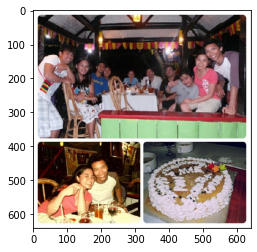

In [5]:
img = cv2.imread("test_img/img1.jpg")
bbox = pd.read_csv("test_img/test_bbox1.csv")
cls_labels = pd.read_csv("test_img/class_labels1.csv")
plt.imshow(img[:,:,[2,1,0]])
print(img.shape)

In [6]:
img = resize(img)
print(img.shape)

(600, 600, 3)


In [7]:
bbox=bbox.drop(['Unnamed: 0'],axis=1)
cls_labels = cls_labels.drop(['Unnamed: 0'],axis=1)
imdb = pd.DataFrame()
imdb['x1'] = bbox['XMin']*img.shape[1]
imdb['x2'] = bbox['XMax']*img.shape[1]
imdb['y1'] = bbox['YMin']*img.shape[0]
imdb['y2'] = bbox['YMax']*img.shape[0]

imdb['class']=bbox.join(cls_labels.set_index('Name'),on='LabelName')['Class']
imdb

x1        x2        y1        y2   class
0     7.5000  117.1872   89.0628  352.5000  Person
1    15.0000  165.9378  428.4378  569.0628  Person
2    90.9372  186.5622  119.0622  354.3750  Person
3   153.7500  257.8128  390.9378  555.0000  Person
4   154.6872  208.1250  141.5628  231.5628  Person
5   192.1872  221.2500  156.5628  196.8750  Person
6   247.5000  567.1872   72.1872  285.0000  Person
7   316.8750  554.0622  405.0000  578.4378   Dairy
8    38.4372  295.3128  533.4378  596.2500   Table
9   180.9372  594.3750  277.5000  357.1872   Table
10  187.5000  346.8750  210.9372  278.4378   Table
11  314.0628  556.8750  401.2500  588.7500    Cake
12  315.0000  552.1878  398.4372  585.9372  Pastry

In [8]:
imdb['class'].loc[imdb['class']!='Person']='bg'
imdb

C:\Users\april\Anaconda3\envs\obj-detection\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


x1        x2        y1        y2   class
0     7.5000  117.1872   89.0628  352.5000  Person
1    15.0000  165.9378  428.4378  569.0628  Person
2    90.9372  186.5622  119.0622  354.3750  Person
3   153.7500  257.8128  390.9378  555.0000  Person
4   154.6872  208.1250  141.5628  231.5628  Person
5   192.1872  221.2500  156.5628  196.8750  Person
6   247.5000  567.1872   72.1872  285.0000  Person
7   316.8750  554.0622  405.0000  578.4378      bg
8    38.4372  295.3128  533.4378  596.2500      bg
9   180.9372  594.3750  277.5000  357.1872      bg
10  187.5000  346.8750  210.9372  278.4378      bg
11  314.0628  556.8750  401.2500  588.7500      bg
12  315.0000  552.1878  398.4372  585.9372      bg

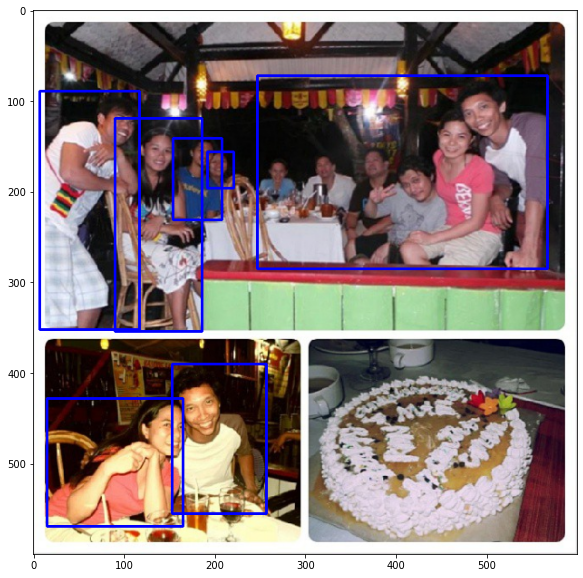

In [9]:
#plotting rectangles
plot_rectangles(imdb,img)

In [10]:
y_rpn_cls, y_rpn_regr, num_pos = generate_anchor_boxes(imdb,img.shape[0],img.shape[1],img.shape[0],img.shape[1])
print(y_rpn_cls.shape, y_rpn_regr.shape, num_pos)

(1, 37, 37, 18) (1, 37, 37, 72) 22


pos_cnt: 22, neg_cnt: 234


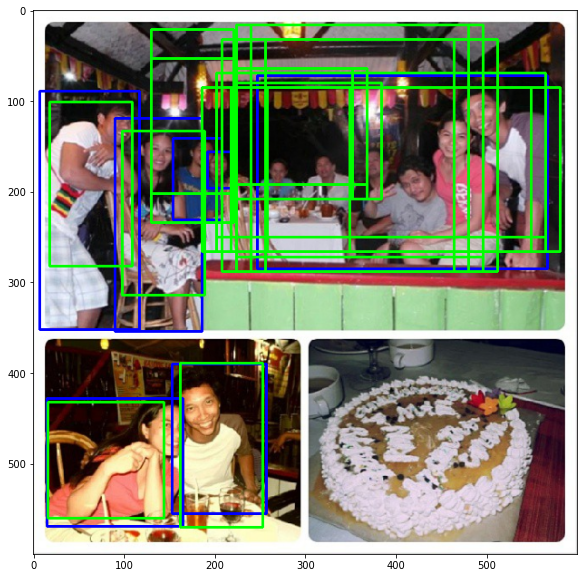

In [11]:
plot_boxes(img,y_rpn_cls)
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,[2,1,0]])

## Test Image 2

(1067, 1600, 3)


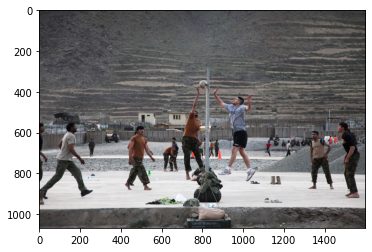

In [12]:
img = cv2.imread("test_img/img2.jpg")
bbox = pd.read_csv("test_img/test_bbox2.csv")
cls_labels = pd.read_csv("test_img/class_labels2.csv")
plt.imshow(img[:,:,[2,1,0]])
print(img.shape)

In [13]:
img = resize(img)
print(img.shape)

(600, 899, 3)


In [14]:
bbox=bbox.drop(['Unnamed: 0'],axis=1)
cls_labels = cls_labels.drop(['Unnamed: 0'],axis=1)
imdb = pd.DataFrame()
imdb['x1'] = bbox['XMin']*img.shape[1]
imdb['x2'] = bbox['XMax']*img.shape[1]
imdb['y1'] = bbox['YMin']*img.shape[0]
imdb['y2'] = bbox['YMax']*img.shape[0]

imdb['class']=bbox.join(cls_labels.set_index('Name'),on='LabelName')['Class']
imdb

x1          x2        y1        y2     class
0     0.000000   26.408125  309.8406  473.4768       Man
1     0.000000  153.953750  305.9046  537.0198       Man
2   134.850000  156.201250  353.1396  405.4356       Man
3   235.425625  316.897500  318.8376  497.6568       Man
4   241.044375  309.593125  335.7078  484.7238       Man
5   340.496250  385.446250  373.3836  444.2364       Man
6   359.600000  386.570000  350.8902  446.4852       Man
7   391.065000  462.423125  209.1846  470.1030       Man
8   476.470000  597.835000  209.7468  470.6652       Man
9   482.088750  498.945000  358.2006  405.4356       Man
10  632.109375  645.594375  342.4554  360.4500       Man
11  646.718125  660.765000  358.2006  376.7574       Man
12  648.965625  663.012500  342.4554  359.3250       Man
13  665.260000  682.116250  356.5134  384.0672       Man
14  679.306875  696.163125  359.3250  405.4356       Man
15  696.163125  750.665000  349.7658  377.8818       Man
16  734.932500  808.538125  330.0846  497.6568       Man
17  790.558125  809.661875  344.7048  375.6324       Man
18  810.785625  825.956250  343.5804  374.5080       Man
19  817.528125  887.762500  305.9046  515.0892       Man
20    1.123750   13.485000  497.6568  533.6460  Footwear
21   13.485000   21.913125  502.1556  519.5874  Footwear
22  114.060625  147.211250  493.1586  512.8398  Footwear
23  492.764375  524.791250  430.7406  451.5462  Footwear
24  567.493750  595.587500  435.8016  472.3524  Footwear
25  615.815000  628.738125  512.8398  528.0222  Footwear
26  633.233125  652.898750  456.0450  477.9756  Footwear
27  638.851875  669.193125  515.0892  530.2716  Footwear
28  649.527500  664.698125  457.7322  481.9116  Footwear

In [15]:
imdb['class'].loc[imdb['class']!='Man']='bg'
imdb

C:\Users\april\Anaconda3\envs\obj-detection\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


x1          x2        y1        y2 class
0     0.000000   26.408125  309.8406  473.4768   Man
1     0.000000  153.953750  305.9046  537.0198   Man
2   134.850000  156.201250  353.1396  405.4356   Man
3   235.425625  316.897500  318.8376  497.6568   Man
4   241.044375  309.593125  335.7078  484.7238   Man
5   340.496250  385.446250  373.3836  444.2364   Man
6   359.600000  386.570000  350.8902  446.4852   Man
7   391.065000  462.423125  209.1846  470.1030   Man
8   476.470000  597.835000  209.7468  470.6652   Man
9   482.088750  498.945000  358.2006  405.4356   Man
10  632.109375  645.594375  342.4554  360.4500   Man
11  646.718125  660.765000  358.2006  376.7574   Man
12  648.965625  663.012500  342.4554  359.3250   Man
13  665.260000  682.116250  356.5134  384.0672   Man
14  679.306875  696.163125  359.3250  405.4356   Man
15  696.163125  750.665000  349.7658  377.8818   Man
16  734.932500  808.538125  330.0846  497.6568   Man
17  790.558125  809.661875  344.7048  375.6324   Man
18  810.785625  825.956250  343.5804  374.5080   Man
19  817.528125  887.762500  305.9046  515.0892   Man
20    1.123750   13.485000  497.6568  533.6460    bg
21   13.485000   21.913125  502.1556  519.5874    bg
22  114.060625  147.211250  493.1586  512.8398    bg
23  492.764375  524.791250  430.7406  451.5462    bg
24  567.493750  595.587500  435.8016  472.3524    bg
25  615.815000  628.738125  512.8398  528.0222    bg
26  633.233125  652.898750  456.0450  477.9756    bg
27  638.851875  669.193125  515.0892  530.2716    bg
28  649.527500  664.698125  457.7322  481.9116    bg

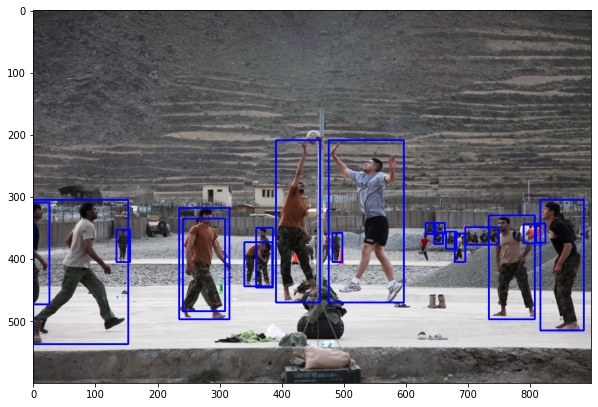

In [16]:
#plotting rectangles
plot_rectangles(imdb,img)

In [17]:
y_rpn_cls, y_rpn_regr, num_pos = generate_anchor_boxes(imdb,img.shape[0],img.shape[1],img.shape[0],img.shape[1])
print(y_rpn_cls.shape, y_rpn_regr.shape, num_pos)

(1, 37, 56, 18) (1, 37, 56, 72) 28


pos_cnt: 28, neg_cnt: 228


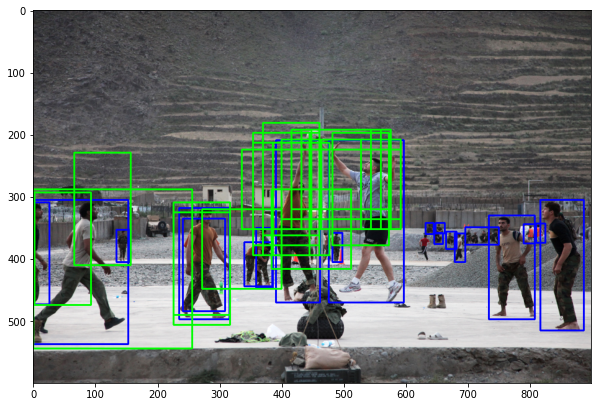

In [18]:
plot_boxes(img,y_rpn_cls)
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,[2,1,0]])

# RPN LOSS

In [19]:
from rpn.train import *
from rpn.rpn_layer import rpn_layer
base = base_model.Base()
fmap = base.get_fmap(Input(img.shape))
rpn_cls, rpn_regr = rpn_layer(fmap) #rpn_layer

In [20]:
print(rpn_cls.shape)
print(rpn_regr.shape)
print(y_rpn_cls.shape)
print(y_rpn_regr.shape)

(None, 37, 56, 9)
(None, 37, 56, 36)
(1, 37, 56, 18)
(1, 37, 56, 72)


In [21]:
cls_loss_fn, regr_loss_fn = rpn_cls_loss(9), rpn_regr_loss(9)
cls_loss = cls_loss_fn(y_rpn_cls,rpn_cls)
regr_loss = regr_loss_fn(y_rpn_regr, rpn_regr)
print(cls_loss)
print(regr_loss)

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.truediv/truediv:0', description="created by layer 'tf.math.truediv'")
KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.truediv_2/truediv:0', description="created by layer 'tf.math.truediv_2'")


# Data Augmenter 

In [22]:
import copy
from data_augmentation import augment
img = cv2.imread("test_img/img1.jpg")
bbox = pd.read_csv("test_img/test_bbox1.csv")
cls_labels = pd.read_csv("test_img/class_labels1.csv")
aug_img = copy.deepcopy(img)

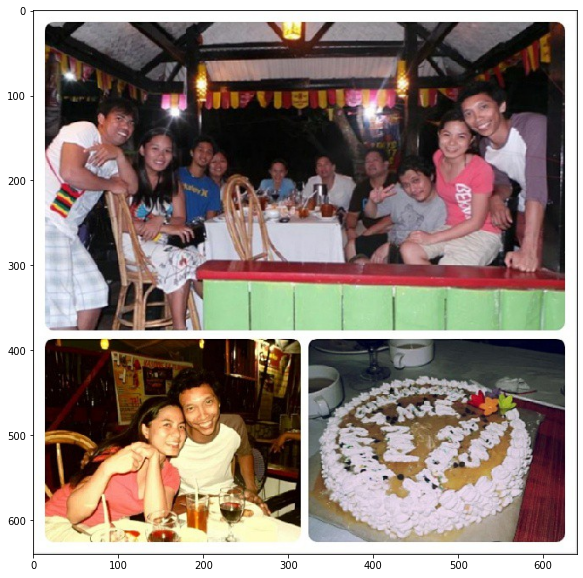

In [23]:
plt.figure(figsize = (10,10))
plt.imshow(aug_img[:,:,[2,1,0]])

In [24]:
bbox=bbox.drop(['Unnamed: 0'],axis=1)
cls_labels = cls_labels.drop(['Unnamed: 0'],axis=1)
imdb = pd.DataFrame()
imdb['x1'] = bbox['XMin']*img.shape[1]
imdb['x2'] = bbox['XMax']*img.shape[1]
imdb['y1'] = bbox['YMin']*img.shape[0]
imdb['y2'] = bbox['YMax']*img.shape[0]

imdb['class']=bbox.join(cls_labels.set_index('Name'),on='LabelName')['Class']
imdb

x1         x2         y1         y2   class
0     8.00000  124.99968   95.00032  376.00000  Person
1    16.00000  177.00032  457.00032  607.00032  Person
2    96.99968  198.99968  126.99968  378.00000  Person
3   164.00000  275.00032  417.00032  592.00000  Person
4   164.99968  222.00000  151.00032  247.00032  Person
5   204.99968  236.00000  167.00032  210.00000  Person
6   264.00000  604.99968   76.99968  304.00000  Person
7   338.00000  590.99968  432.00000  617.00032   Dairy
8    40.99968  315.00032  569.00032  636.00000   Table
9   192.99968  634.00000  296.00000  380.99968   Table
10  200.00000  370.00000  224.99968  297.00032   Table
11  335.00032  594.00000  428.00000  628.00000    Cake
12  336.00000  589.00032  424.99968  624.99968  Pastry

In [25]:
aug_imdb, aug_img = augment(aug_img,imdb)

In [26]:
aug_imdb

x1         x2         y1         y2   class
0   515.00032  632.00000   95.00032  376.00000  Person
1   462.99968  624.00000  457.00032  607.00032  Person
2   441.00032  543.00032  126.99968  378.00000  Person
3   364.99968  476.00000  417.00032  592.00000  Person
4   418.00000  475.00032  151.00032  247.00032  Person
5   404.00000  435.00032  167.00032  210.00000  Person
6    35.00032  376.00000   76.99968  304.00000  Person
7    49.00032  302.00000  432.00000  617.00032   Dairy
8   324.99968  599.00032  569.00032  636.00000   Table
9     6.00000  447.00032  296.00000  380.99968   Table
10  270.00000  440.00000  224.99968  297.00032   Table
11   46.00000  304.99968  428.00000  628.00000    Cake
12   50.99968  304.00000  424.99968  624.99968  Pastry

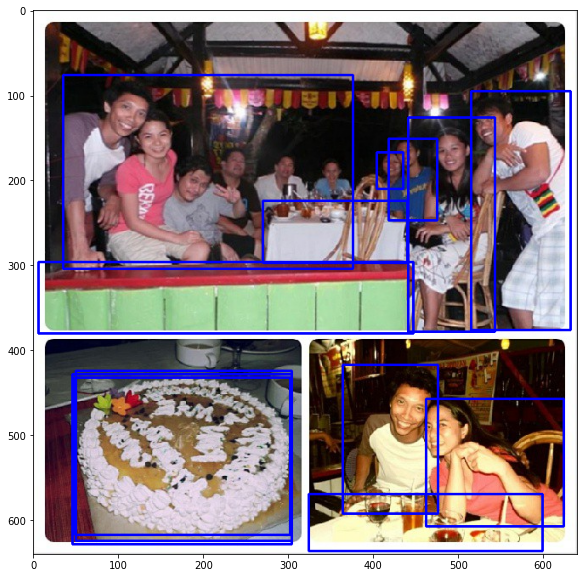

In [27]:
plot_rectangles(aug_imdb, aug_img)